In [1]:
import tensorflow as tf  
from tensorflow.keras import backend as K  

def f1_score(y_true, y_pred):  
    # Calculate Precision and Recall  
    y_pred_binary = K.round(y_pred)  
    tp = K.sum(K.cast(y_true * y_pred_binary, 'float'), axis=0)  
    fp = K.sum(K.cast((1-y_true) * y_pred_binary, 'float'), axis=0)  
    fn = K.sum(K.cast(y_true * (1-y_pred_binary), 'float'), axis=0)  

    # Calculate Precision, Recall and F1  
    p = tp / (tp + fp + K.epsilon())  
    r = tp / (tp + fn + K.epsilon())  

    f1 = 2*p*r / (p+r+K.epsilon())  
    f1 = K.mean(f1)  
    return f1  

batch_size = 10  
img_height = 160  
img_width = 160  
  
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,  
    rotation_range=20,  
    width_shift_range=0.2,  
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)  
  
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)  
  
train_generator = train_datagen.flow_from_directory(  
    'dataset/training',  
    target_size=(img_height, img_width),  
    batch_size=batch_size,  
    class_mode='binary'  
)  
  
validation_generator = test_datagen.flow_from_directory(  
    'dataset/test',  
    target_size=(img_height, img_width),  
    batch_size=batch_size,  
    class_mode='binary'  
)  

Found 53 images belonging to 2 classes.
Found 15 images belonging to 2 classes.


In [2]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),  
                                               include_top=False,  
                                               weights='imagenet')  
  
base_model.trainable = False  # Freeze the base model  
  
model = tf.keras.Sequential([  
    base_model,  
    tf.keras.layers.GlobalAveragePooling2D(),  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])  
  
model.compile(optimizer='adam',  
              loss='binary_crossentropy',  
              metrics=['accuracy', f1_score])  

In [3]:
history = model.fit(  
    train_generator,  
    steps_per_epoch=train_generator.samples // batch_size,  
    epochs=10,  
    validation_data=validation_generator,  
    validation_steps=validation_generator.samples // batch_size  
)  

Epoch 1/10
5/5 [==============================] - 2s 147ms/step - loss: 0.6577 - accuracy: 0.6047 - f1_score: 0.7318 - val_loss: 0.4844 - val_accuracy: 0.9000 - val_f1_score: 0.9333
Epoch 2/10
5/5 [==============================] - 0s 67ms/step - loss: 0.5410 - accuracy: 0.7209 - f1_score: 0.8253 - val_loss: 0.4894 - val_accuracy: 0.9000 - val_f1_score: 0.9412
Epoch 3/10
5/5 [==============================] - 0s 69ms/step - loss: 0.5681 - accuracy: 0.7400 - f1_score: 0.8441 - val_loss: 0.5792 - val_accuracy: 0.7000 - val_f1_score: 0.7692
Epoch 4/10
5/5 [==============================] - 0s 58ms/step - loss: 0.4746 - accuracy: 0.8372 - f1_score: 0.9109 - val_loss: 0.5171 - val_accuracy: 0.7000 - val_f1_score: 0.7692
Epoch 5/10
5/5 [==============================] - 0s 63ms/step - loss: 0.4696 - accuracy: 0.8140 - f1_score: 0.8727 - val_loss: 0.3523 - val_accuracy: 1.0000 - val_f1_score: 1.0000
Epoch 6/10
5/5 [==============================] - 0s 61ms/step - loss: 0.4862 - accuracy: 0.76

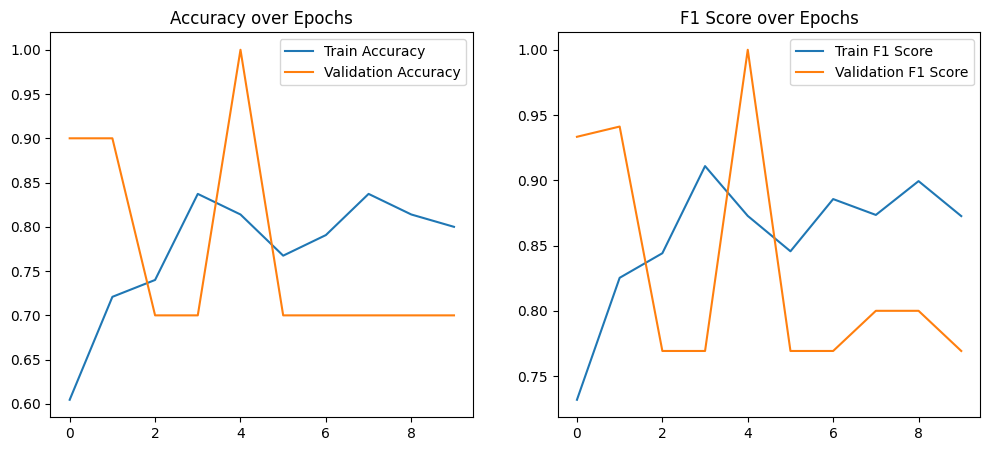

In [4]:
import matplotlib.pyplot as plt  
  
# Accuracy and F1 Score  
plt.figure(figsize=(12, 5))  
plt.subplot(1, 2, 1)  
plt.plot(history.history['accuracy'], label='Train Accuracy')  
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  
plt.title('Accuracy over Epochs')  
plt.legend()  
  
plt.subplot(1, 2, 2)  
plt.plot(history.history['f1_score'], label='Train F1 Score')  
plt.plot(history.history['val_f1_score'], label='Validation F1 Score')  
plt.title('F1 Score over Epochs')  
plt.legend()  
  
plt.show()  

In [12]:
from tensorflow.keras.preprocessing import image  
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input  
import numpy as np  
  
def load_preprocess_image(img_path, target_size=(160, 160)):  
    # Load the image  
    img = image.load_img(img_path, target_size=target_size)  
    # Convert the image to a numpy array  
    img_array = image.img_to_array(img)  
    # Expand dimensions to fit the model input  
    img_array = np.expand_dims(img_array, axis=0)  
    # Preprocess the image  
    img_array = preprocess_input(img_array)  
    return img_array  

def predict_image_class(model, img_path):  
    # Load and preprocess the image  
    processed_img = load_preprocess_image(img_path)  
  
    # Predict the class  
    prediction = model.predict(processed_img)
    print(prediction)
    prediction = (prediction > 0.5)[0][0]  
  
    # Assuming class indices are {0: 'normal', 1: 'broken'}  
    class_labels = {0: 'anomaly', 1: 'good'}  
      
    # Return the predicted class  
    return class_labels[int(prediction)]  

In [13]:
predicted_class = predict_image_class(model, 'test/anomaly2.jpg')  
print(f"The predicted class for the image is: {predicted_class}")
predicted_class = predict_image_class(model, 'test/good.jpg')  
print(f"The predicted class for the image is: {predicted_class}")
predicted_class = predict_image_class(model, 'test/anomaly.jpg')  
print(f"The predicted class for the image is: {predicted_class}")

1/1 [==============================] - 0s 22ms/step
[[0.06783276]]
The predicted class for the image is: anomaly
1/1 [==============================] - 0s 18ms/step
[[0.4015378]]
The predicted class for the image is: anomaly
1/1 [==============================] - 0s 18ms/step
[[0.63449275]]
The predicted class for the image is: good
